In [1]:
import os
import glob
import wget
import numpy as np
import pandas as pd
from PIL import Image
from pyproj import CRS
import rasterio as rio
import geopandas as gpd

# Inputs Paths
1. AOI polygon.

2. EPSG UTM code.

In [2]:
original_geo_espg_code = 4326

In [3]:
project_name = "gran_canyon"

In [4]:
aoi_polygon_fp = f"/home/rllop/PERSONAL/{project_name}_project/{project_name}_aoi.gpkg"
copernicus_30_coverage_grid_fp = "/home/rllop/PERSONAL/copernicus_dem_coverage/copernicus_30_grid_coverage_test.gpkg"

In [5]:
aoi_polygon = gpd.read_file(aoi_polygon_fp)
# utm_epsg_code = 3829 # Taiwan
# utm_epsg_code = 3042 Huesca
# utm_epsg_code = 6207 # Nepal
# utm_epsg_code = 6634 # Hawai
utm_epsg_code = 3742 # Gran Cnayon

In [6]:
aoi_polygon_fp

'/home/rllop/PERSONAL/gran_canyon_project/gran_canyon_aoi.gpkg'

# Intermediate Output Data Paths

In [7]:
dem_directory_fp = f"/home/rllop/PERSONAL/copernicus_dem_coverage/{project_name}/*"
dem_download_directory_fp = f"/home/rllop/PERSONAL/copernicus_dem_coverage/{project_name}/"
output_merge_fp = f"/home/rllop/PERSONAL/{project_name}_project/{project_name}_Copernicus_DSM_10_MERGE.tif"
output_clip_fp = f"/home/rllop/PERSONAL/{project_name}_project/{project_name}_Copernicus_DSM_10_MERGE_CLIP.tif"
output_merge_clip_utm_fp = f"/home/rllop/PERSONAL/{project_name}_project/{project_name}_Copernicus_DSM_10_MERGE_CLIP_UTM_{utm_epsg_code}.tif"

# Ouput Paths

In [8]:
final_output_raster_fp = f"/home/rllop/PERSONAL/{project_name}_project/{project_name}_Copernicus_DSM_10_MERGE_CLIP_UTM_{utm_epsg_code}_RESCALE.tif"
inside_aoi_png_output_fp = f"/home/rllop/PERSONAL/{project_name}_project/{project_name}_inside_mask.png"
outside_aoi_png_output_fp = f"/home/rllop/PERSONAL/{project_name}_project/{project_name}_outside_mask.png"
# polygon_raster_fp = "./huesca_project/river_huesca_clipped_raster.tif"

# Create list of Copernicus DEM urls

In [9]:
copernicus_30_coverage_grid = gpd.read_file(copernicus_30_coverage_grid_fp)

In [10]:
aoi_polygon = gpd.read_file(aoi_polygon_fp)

In [11]:
aoi_polygon_box = gpd.GeoDataFrame(columns=['geometry'])
aoi_polygon_box = aoi_polygon_box.set_geometry('geometry')
aoi_polygon_box = aoi_polygon_box.set_crs(4326)
aoi_polygon_box['geometry'] = gpd.GeoDataFrame(aoi_polygon.envelope)

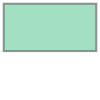

In [12]:
aoi_polygon_box.geometry[0]

In [13]:
copernicus_grids_intersection = copernicus_30_coverage_grid.sjoin(aoi_polygon_box)

In [14]:
copernicus_grids_intersection.dtypes

GeoCellID        object
04_DGED_19       object
03_INSP_19       object
10_DGED_19       object
10_DTED_19       object
30_DGED_19       object
30_DTED_19       object
Product04        object
Product03        object
Product10        object
Product30        object
04_DGED_20       object
03_INSP_20       object
10_DGED_20       object
10_DTED_20       object
30_DGED_20       object
30_DTED_20       object
04_DGED_21       object
03_INSP_21       object
10_DGED_21       object
10_DTED_21       object
30_DGED_21       object
30_DTED_21       object
UpRational       object
geometry       geometry
index_right       int64
dtype: object

In [15]:
copernicus_grids_intersection[['Product04', 'Product03', 'Product10', 'Product30']].head()

,Product04,Product03,Product10,Product30
5039,None,None,Copernicus_DSM_10_N35_00_W112_00,Copernicus_DSM_30_N35_00_W112_00
5040,None,None,Copernicus_DSM_10_N35_00_W113_00,Copernicus_DSM_30_N35_00_W113_00
5041,None,None,Copernicus_DSM_10_N35_00_W114_00,Copernicus_DSM_30_N35_00_W114_00
5042,None,None,Copernicus_DSM_10_N35_00_W115_00,Copernicus_DSM_30_N35_00_W115_00
5225,None,None,Copernicus_DSM_10_N36_00_W112_00,Copernicus_DSM_30_N36_00_W112_00


In [16]:
copernicus_grids_intersection['Product10'].values[0]

'Copernicus_DSM_10_N35_00_W112_00'

In [17]:
copernicus_grids_intersection['Product10'].head()

5039    Copernicus_DSM_10_N35_00_W112_00
5040    Copernicus_DSM_10_N35_00_W113_00
5041    Copernicus_DSM_10_N35_00_W114_00
5042    Copernicus_DSM_10_N35_00_W115_00
5225    Copernicus_DSM_10_N36_00_W112_00
Name: Product10, dtype: object

In [18]:
dem_url_list = []
for grid_value in copernicus_grids_intersection['Product10'].values:
    value = '_'.join(grid_value.split('_')[3:])
    # print(value)
    dem_url = f"https://copernicus-dem-30m.s3.eu-central-1.amazonaws.com/Copernicus_DSM_COG_10_{value}_DEM/Copernicus_DSM_COG_10_{value}_DEM.tif"
    dem_url_list.append(dem_url)
    # Download each DEM into copernicus region folder
    print(dem_url)
    dem_fp = dem_download_directory_fp + dem_url.split("/")[-1]
    print(dem_fp)
    wget.download(dem_url, dem_fp)

https://copernicus-dem-30m.s3.eu-central-1.amazonaws.com/Copernicus_DSM_COG_10_N35_00_W112_00_DEM/Copernicus_DSM_COG_10_N35_00_W112_00_DEM.tif
/home/rllop/PERSONAL/copernicus_dem_coverage/gran_canyon/Copernicus_DSM_COG_10_N35_00_W112_00_DEM.tif
https://copernicus-dem-30m.s3.eu-central-1.amazonaws.com/Copernicus_DSM_COG_10_N35_00_W113_00_DEM/Copernicus_DSM_COG_10_N35_00_W113_00_DEM.tif
/home/rllop/PERSONAL/copernicus_dem_coverage/gran_canyon/Copernicus_DSM_COG_10_N35_00_W113_00_DEM.tif
https://copernicus-dem-30m.s3.eu-central-1.amazonaws.com/Copernicus_DSM_COG_10_N35_00_W114_00_DEM/Copernicus_DSM_COG_10_N35_00_W114_00_DEM.tif
/home/rllop/PERSONAL/copernicus_dem_coverage/gran_canyon/Copernicus_DSM_COG_10_N35_00_W114_00_DEM.tif
https://copernicus-dem-30m.s3.eu-central-1.amazonaws.com/Copernicus_DSM_COG_10_N35_00_W115_00_DEM/Copernicus_DSM_COG_10_N35_00_W115_00_DEM.tif
/home/rllop/PERSONAL/copernicus_dem_coverage/gran_canyon/Copernicus_DSM_COG_10_N35_00_W115_00_DEM.tif
https://copernicus-d

# Merge all DEM products into one raster

In [9]:
merge_cmd = f"gdal_merge.py -init 0 -a_nodata 0 -o {output_merge_fp}"

In [10]:
dem_url_list = list(glob.iglob(dem_directory_fp, recursive=True))

In [11]:
# Create merge command
for url in dem_url_list:
 merge_cmd = merge_cmd + " " + url

In [12]:
merge_cmd

'gdal_merge.py -init 0 -a_nodata 0 -o /home/rllop/PERSONAL/gran_canyon_project/gran_canyon_Copernicus_DSM_10_MERGE.tif /home/rllop/PERSONAL/copernicus_dem_coverage/gran_canyon/Copernicus_DSM_COG_10_N37_00_W115_00_DEM.tif /home/rllop/PERSONAL/copernicus_dem_coverage/gran_canyon/Copernicus_DSM_COG_10_N35_00_W112_00_DEM.tif /home/rllop/PERSONAL/copernicus_dem_coverage/gran_canyon/Copernicus_DSM_COG_10_N35_00_W115_00_DEM.tif /home/rllop/PERSONAL/copernicus_dem_coverage/gran_canyon/Copernicus_DSM_COG_10_N36_00_W112_00_DEM.tif /home/rllop/PERSONAL/copernicus_dem_coverage/gran_canyon/Copernicus_DSM_COG_10_N37_00_W112_00_DEM.tif /home/rllop/PERSONAL/copernicus_dem_coverage/gran_canyon/Copernicus_DSM_COG_10_N36_00_W115_00_DEM.tif /home/rllop/PERSONAL/copernicus_dem_coverage/gran_canyon/Copernicus_DSM_COG_10_N35_00_W114_00_DEM.tif /home/rllop/PERSONAL/copernicus_dem_coverage/gran_canyon/Copernicus_DSM_COG_10_N35_00_W113_00_DEM.tif /home/rllop/PERSONAL/copernicus_dem_coverage/gran_canyon/Copernic

In [13]:
os.system(merge_cmd)

0

# Clip DEM to polygon

## STEP 1:
- Clip raster to Polygon Envelope Bounding box
## STEP 2:
- Rasterize polygon and burn value of 1 in inside, else 0 or np.nan. Depends on how Blender GIS deals with missing data.
## STEP 3: 
- Multiply clipped DEM with rasterize polygon.



In [14]:
aoi_polygon.bounds

,minx,miny,maxx,maxy
0,-113.979289,35.745728,-111.632446,36.818522


In [15]:
xmin = aoi_polygon.bounds['minx'][0]
ymin = aoi_polygon.bounds['miny'][0]
xmax = aoi_polygon.bounds['maxx'][0]
ymax = aoi_polygon.bounds['maxy'][0]

In [16]:
#-te <xmin ymin xmax ymax>

In [17]:
cmd = f"gdalwarp -of GTiff -te {xmin} {ymin} {xmax} {ymax} -cutline {aoi_polygon_fp}  -crop_to_cutline {output_merge_fp}  {output_clip_fp}"

In [18]:
cmd

'gdalwarp -of GTiff -te -113.97928873697917 35.7457275390625 -111.6324462890625 36.81852213541667 -cutline /home/rllop/PERSONAL/gran_canyon_project/gran_canyon_aoi.gpkg  -crop_to_cutline /home/rllop/PERSONAL/gran_canyon_project/gran_canyon_Copernicus_DSM_10_MERGE.tif  /home/rllop/PERSONAL/gran_canyon_project/gran_canyon_Copernicus_DSM_10_MERGE_CLIP.tif'

In [19]:
os.system(cmd)

0

# Reproject raster to UTM coordinates

In [20]:
src_raster = rio.open(output_clip_fp)

In [21]:
src_raster.width

8447

In [22]:
src_raster.height

3861

In [23]:
cmd = f"gdalwarp -overwrite {output_clip_fp} {output_merge_clip_utm_fp} -s_srs EPSG:{original_geo_espg_code} -t_srs EPSG:{utm_epsg_code} -r cubicspline -ot UInt16 -dstnodata np.nan"

In [24]:
os.system(cmd)

0

# Rescale raster to 16 bit values 

rescale formula = (Pixel Value – Lowest Value) ÷ (Highest Value – Lowest Value) * 65,535

In [25]:
raster_src = rio.open(output_merge_clip_utm_fp)
raster_arr = raster_src.read(1)

In [26]:
np.unique(raster_arr)

array([   0,  350,  351, ..., 2796, 2797, 2798], dtype=uint16)

In [27]:
# Island Elevation Factoring 
# raster_arr = np.where(raster_arr>0, raster_arr+100, raster_arr)

In [28]:
np.unique(raster_arr)

array([   0,  350,  351, ..., 2796, 2797, 2798], dtype=uint16)

In [29]:
raster_arr.dtype

dtype('uint16')

In [30]:
raster_arr

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint16)

In [31]:
raster_src.crs

CRS.from_epsg(3742)

In [32]:
raster_max = np.max(raster_arr)
raster_min = np.min(raster_arr)

In [33]:
def f(x):
    return ((x - raster_min)/(raster_max-raster_min))*65535

def rescale_array(x):
    return np.array(list(map(f, x)))

In [34]:
raster_arr_rescale = rescale_array(raster_arr).astype(np.uint16)

In [35]:
raster_arr_rescale.dtype

dtype('uint16')

In [36]:
np.unique(raster_arr_rescale)

array([    0,  8197,  8221, ..., 65488, 65511, 65535], dtype=uint16)

In [37]:
# Save raster layer function
def save_raster_layer(arr, epsg_utm_code, src_fp, out_fp):
    """
    Saves the input numpy array with the dimensions of the specified source raster (usually the DTM)
    :param arr: Numpy array that is going to be saved as raster
    :param epsg_utm: EPSG utm code in decided for the flood event in the form of 'EPSG:XXXX'
    :param src_fp: Source raster used to obtain consistent extent dimensions.
    :param out_fp: Output path where raster will be saved
    """
    src = rio.open(src_fp)
    src_arr = src.read(1)
    crs = CRS.from_epsg(epsg_utm_code)
    new_raster = rio.open(
        out_fp,
        'w',
        driver='GTiff',
        height=arr.shape[0],
        width=arr.shape[1],
        count=1,
        dtype=src_arr.dtype,
        crs=crs,
        transform=src.transform,
    )
    new_raster.write(arr, 1)
    new_raster.close()
    print('New raster feature was saved.')

In [38]:
raster_src.transform

Affine(26.062392963066877, 0.0, 230611.05711433815,
       0.0, -26.062392963066877, 4078876.5775026665)

In [39]:
raster_arr_rescale.dtype

dtype('uint16')

In [40]:
save_raster_layer(raster_arr_rescale, utm_epsg_code, output_merge_clip_utm_fp, final_output_raster_fp)

New raster feature was saved.


# Create Mask For Inside & Outside Polygon AOI as png file

In [41]:
import PIL
from PIL import Image, ImageOps
PIL.Image.MAX_IMAGE_PIXELS = 933120000

In [42]:
img = Image.open(final_output_raster_fp)

In [43]:
final_output_raster_fp

'/home/rllop/PERSONAL/gran_canyon_project/gran_canyon_Copernicus_DSM_10_MERGE_CLIP_UTM_3742_RESCALE.tif'

In [44]:
img.size

(8171, 4716)

In [45]:
# img.show()

In [46]:
rgba = img.convert('RGBA')
data = rgba.getdata()

In [47]:
data

In [48]:
# RGBA - black (0, 0, 0)
newData = []
for item in data:
    if item[0] == 0 and item[1] == 0 and item[2] == 0:
        newData.append((0, 0, 0, 0))
    elif item[0] != 0 and item[1] != 0 and item[2] != 0:
        newData.append((255, 255, 255, 255))
    else:
        newData.append(item)

In [49]:
rgba.putdata(newData)
rgba.save(inside_aoi_png_output_fp, 'PNG')

In [50]:
# RGBA - black (0, 0, 0)
newData = []
for item in data:
    if item[0] == 0 and item[1] == 0 and item[2] == 0:
        newData.append((255, 255,255, 255))
    elif item[0] != 0 and item[1] != 0 and item[2] != 0:
        newData.append((0, 0, 0, 0))
    else:
        newData.append(item)

In [51]:
rgba.putdata(newData)
rgba.save(outside_aoi_png_output_fp, 'PNG')

# Rasterize Other Vector Layers to Final Raster Extent in PNG format

In [140]:
import geopandas as gpd
import matplotlib.pyplot as plt

In [141]:
vector_layer_fp = "/home/rllop/PERSONAL/huesca_project/huesca_rivers_buffered.gpkg"

In [142]:
vector_layer = gpd.read_file(vector_layer_fp)

In [143]:
vector_layer.head()

KeyboardInterrupt: 

In [ ]:
vector_layer.plot()

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
plt.figure(figsize=(550.3, 671.9))
vector_layer.plot().get_figure().savefig('output.png')

In [ ]:
import matplotlib.pyplot as plt
w = 5503
h = 6719
fig = plt.figure(frameon=False)
fig.set_size_inches(w,h)

In [ ]:
rivers['geometry'] = rivers.buffer(20)

In [ ]:
rivers = rivers.to_crs(2062)

In [ ]:
rivers.to_file(polygon_fp, dirver='GPKG')

In [ ]:
src = rio.open(output_raster_fp)

In [ ]:
src.bounds

In [ ]:
xmin = src.bounds.left
ymin = src.bounds.bottom
xmax = src.bounds.right
ymax = src.bounds.top

In [ ]:
cmd = f"gdal_rasterize -burn 1 -te {xmin} {ymin} {xmax} {ymax} -l river_huesca_clipped {polygon_fp} {polygon_raster_fp}"

In [ ]:
os.system(cmd)